<a href="https://colab.research.google.com/github/ChrissyMarie/AerialSilksImageClassification/blob/main/TransferAerials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aerial Silks image classification transfer learning model using resnet50. This model will classify images of 5 different aerial silks poses.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [184]:
# Fixed for our Aerial classes
NUM_CLASSES = 5

# Fixed for color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 5

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 5
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 5
BATCH_SIZE_VALIDATION = 5

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [185]:
#from tensorflow.python.keras.applications import ResNet50
#from tensorflow.python.keras.models import Sequential


### 
### Below systax is available with TensorFlow 1.11 onwards but this upgrade is not available for Kaggle kernel yet
###
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

2.7.0


In [186]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [187]:
model = Sequential()

model.add(ResNet50(include_top = False, weights = "imagenet", pooling = RESNET50_POOLING_AVERAGE))
#more layers
#model.add(Dense(64, activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(Dense(32, activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(Dense(16, activation = 'relu'))
#model.add(Dropout(0.2))

model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model.layers[0].trainable = False

In [188]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_5 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [189]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [190]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        "./gdrive/MyDrive/AerialClassification/AerialTRAINING/",
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        "./gdrive/MyDrive/AerialClassification/AerialTESTING/",
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 257 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [191]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(5, 52, 5, 10)

In [192]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')


In [193]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../working/best.hdf5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 4.4237 - accuracy: 0.1600

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


5/5 [==============================] - 19s 4s/step - loss: 4.4237 - accuracy: 0.1600 - val_loss: 11.6662 - val_accuracy: 0.2400
Epoch 2/30
5/5 [==============================] - 15s 3s/step - loss: 6.6302 - accuracy: 0.3600 - val_loss: 8.7345 - val_accuracy: 0.3400
Epoch 3/30
5/5 [==============================] - 14s 3s/step - loss: 8.2477 - accuracy: 0.5200 - val_loss: 10.3040 - val_accuracy: 0.3400
Epoch 4/30
5/5 [==============================] - 14s 3s/step - loss: 9.6820 - accuracy: 0.4400 - val_loss: 15.6420 - val_accuracy: 0.3000
Epoch 5/30
5/5 [==============================] - 14s 3s/step - loss: 10.0111 - accuracy: 0.4400 - val_loss: 10.6848 - val_accuracy: 0.4200
Epoch 6/30
5/5 [==============================] - 14s 3s/step - loss: 6.8136 - accuracy: 0.5200 - val_loss: 6.6216 - val_accuracy: 0.5000
Epoch 7/30
5/5 [==============================] - 14s 3s/step - loss: 2.6019 - accuracy: 0.6400 - val_loss: 8.0729 - val_accuracy: 0.5400
Epoch 8/30
5/5 [========================

In [195]:
model.save('./gdrive/MyDrive/silks_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


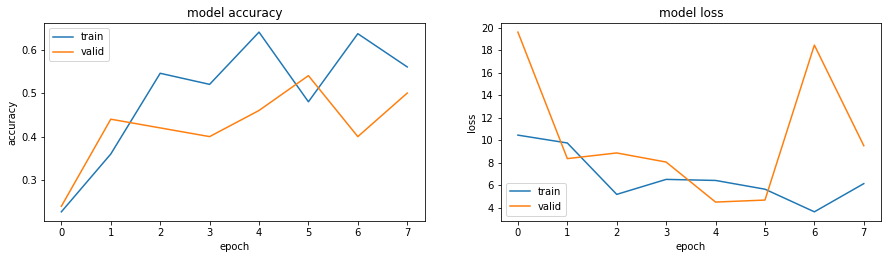

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
model.predict()

In [180]:
test_generator = data_generator.flow_from_directory(
    directory = './gdrive/MyDrive/AerialClassification/AerialTRAINING/',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)


Found 257 images belonging to 5 classes.


'\nfor i in test_generator:\n    #print(test_generator.batch_index, test_generator.batch_size)\n    idx = (test_generator.batch_index - 1) * test_generator.batch_size\n    print(test_generator.filenames[idx : idx + test_generator.batch_size])\n    \n'

In [ ]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


257/257 [==============================] - 54s 205ms/step


In [ ]:
predicted_class_indices

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 3,
       0, 2, 3, 3, 1, 0, 0, 0, 0, 1, 3, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 1, 3, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 4, 1, 1, 0,
       1, 1, 3, 3, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 1, 2,
       2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 0, 1, 1,
       2, 1, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 1, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       3, 3, 1, 3, 3, 4, 3, 1, 3, 1, 4, 3, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4,
       4, 1, 4, 3, 3, 3, 1, 1, 4, 3, 2, 0, 3, 4, 4, 1, 4, 1, 4, 1, 4, 1,
       1, 1, 1, 4, 1, 4, 3, 1, 4, 3, 0, 4, 3, 3, 3])

In [ ]:
TEST_DIR = './gdrive/MyDrive/AerialClassification/AerialTRAINING/'
f, ax = plt.subplots(20, 5, figsize = (20, 30))

# a if condition else b
print(test_generator.class_indices)
names = list(test_generator.class_indices.keys())
pred_text = [names[x] for x in predicted_class_indices]

for i in range(0,100):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    


    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(pred_text[i]))    

plt.show()

In [ ]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('submission.csv', index=False)
results_df.head()

In [183]:
train_generator.reset()

labels = []

for x in train_generator.next():
    if len(x.shape) == 2:
        for y in x:
            labels.append(names[y.tolist().index(1)])

labels


['Belay_Split',
 'Crossback_Straddle',
 'Crossback_Straddle',
 'Gazelle',
 'Gazelle']

In [ ]:
 !pip install coremltools

In [198]:
import coremltools

coreml_model = coremltools.convert(model)

coreml_out_dict = coreml_model.predict({"image":x})
coreml_out = list(coreml_out_dict.values())[0]
np.testing.assert_allclose(tf_out, coreml_out, rtol=1e-2, atol=1e-1)

# convert to an image input Core ML model
# mobilenet model expects images to be normalized in the interval [-1,1]
# hence bias of -1 and scale of 1/127
mlmodel = ct.convert(model,
                    inputs=[ct.ImageType(bias=[-1,-1,-1], scale=1/127)])

mlmodel.save("mobilenet.mlmodel")


coreml_model.save('./gdrive/MyDrive/silks.mlmodel')

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 515/515 [00:03<00:00, 157.56 ops/s]
